## Exo 15

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

dict_keys(['__header__', '__version__', '__globals__', 't', 'x1', 'x2'])


<Figure size 640x480 with 0 Axes>

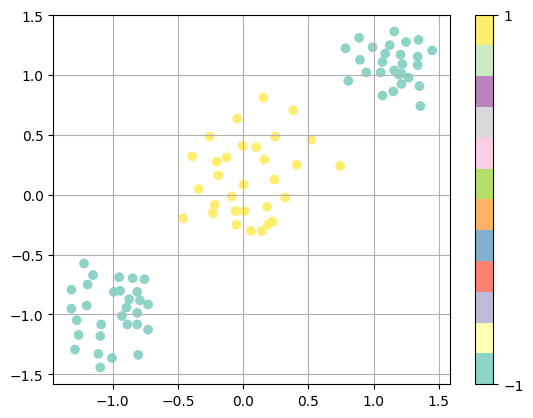

In [41]:
data = loadmat('data4121.mat')
print(data.keys())
t, x1, x2 = data['t'], data['x1'], data['x2']

plt.set_cmap(cmap='Set3')
plt.figure()
plt.scatter(x1, x2, c=t), plt.colorbar(ticks=[-1,1]), plt.grid()
plt.show()

On remarque que les données ne sont pas séparables (enfin, pas dans cette représentation ... alors qu'un petit passage en système radial ..)

In [42]:
# Conversion cartésien -> polaire
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

# Conversion polaire -> cartésien
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

rho, phi = cart2pol(x1, x2)

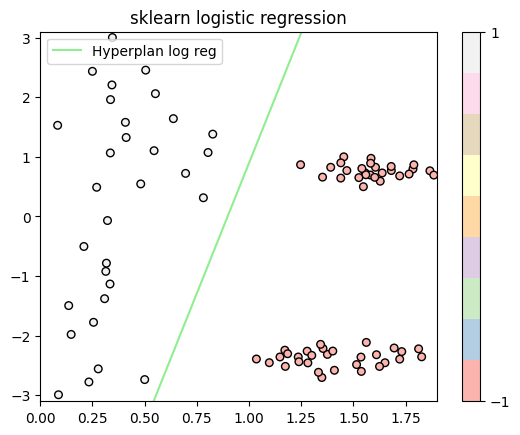

In [58]:
from sklearn.linear_model import LogisticRegression

X = np.column_stack((rho, phi))  # Combiner les caractéristiques en une matrice
y = t.ravel()
model = LogisticRegression()
model.fit(X, y)
w = np.hstack((model.intercept_, model.coef_[0])).reshape((3,1))

rr = np.linspace(np.floor(np.min(rho)), np.ceil(np.max(rho)), 1000)
pp2 = (0 - w[0] - w[1] * rr) / w[2]

plt.figure()
plt.scatter(rho, phi, c=t, cmap='Pastel1', edgecolor='k', s=30)
plt.plot(rr, pp2, 'lightgreen', label='Hyperplan log reg')
plt.title('sklearn logistic regression')
plt.ylim(-3.1,3.1), plt.xlim(0, 1.9), plt.colorbar(ticks=[-1,1])
plt.legend()
plt.show()

Si on veut tracer les frontières de décision pour la représentation cartésienne de nos données, il faut faire une meshgrid, convertir cette meshgrid en polaire, classifier les points, et afficher les labels dans la représentation cartésienne.

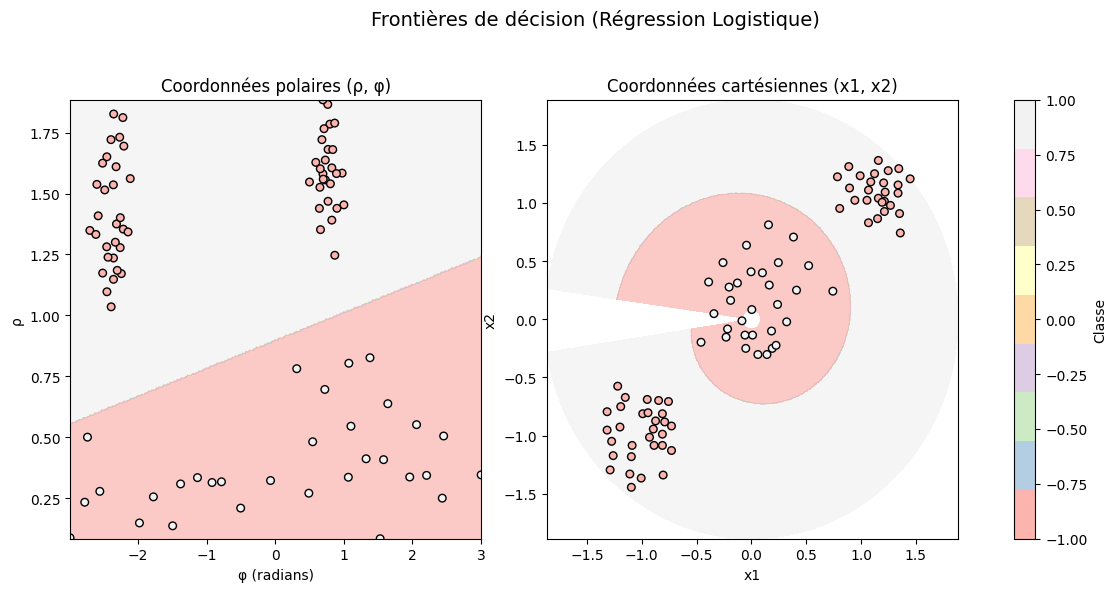

In [55]:
# Préparer les données pour la régression
X = np.column_stack((rho, phi))  # Matrice des caractéristiques en polaire
y = t.ravel()  # Labels aplatis

# Modèle de régression logistique
model = LogisticRegression()
model.fit(X, y)

# Créer un meshgrid pour le plan polaire
rho_min, rho_max = rho.min(), rho.max()
phi_min, phi_max = phi.min(), phi.max()
rho_mesh, phi_mesh = np.meshgrid(
    np.linspace(rho_min, rho_max, 300),
    np.linspace(phi_min, phi_max, 300)
)
X_polar_mesh = np.column_stack((rho_mesh.ravel(), phi_mesh.ravel()))

# Calculer les prédictions en coordonnées polaires
Z_polar = model.predict(X_polar_mesh)
Z_polar = Z_polar.reshape(rho_mesh.shape)

# Conversion des coordonnées polaires du meshgrid en cartésien
xx1, xx2 = pol2cart(rho_mesh, phi_mesh)

# Préparer le plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': None})
fig.suptitle("Frontières de décision (Régression Logistique)", fontsize=14)

# 1. Subplot en coordonnées polaires
axes[0].contourf(phi_mesh, rho_mesh, Z_polar, alpha=0.7, cmap='Pastel1_r')
scatter = axes[0].scatter(phi, rho, c=y, cmap='Pastel1', edgecolor='k', s=30)
axes[0].set_title('Coordonnées polaires (ρ, φ)', fontsize=12)
axes[0].set_xlabel('φ (radians)')
axes[0].set_ylabel('ρ')

# 2. Subplot en coordonnées cartésiennes
axes[1].contourf(xx1, xx2, Z_polar, alpha=0.7, cmap='Pastel1_r')
scatter = axes[1].scatter(x1, x2, c=y, cmap='Pastel1', edgecolor='k', s=30)
axes[1].set_title('Coordonnées cartésiennes (x1, x2)', fontsize=12)
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')

# Ajustements finaux
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuster pour le titre principal
plt.colorbar(scatter, ax=axes, orientation='vertical', label='Classe')
plt.show()

Et que se passe t-il avec une estimation des moindres carrés ? 

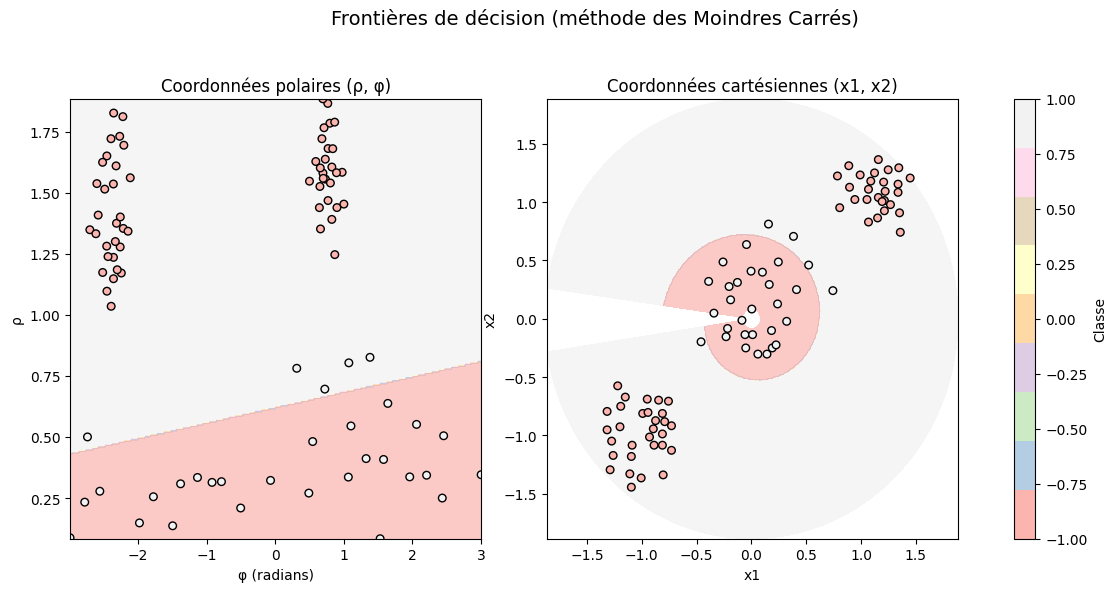

In [54]:
# Ajouter une colonne de biais pour la méthode des moindres carrés
X = np.column_stack((np.ones_like(rho), rho, phi))  # Matrice X avec biais
y = t.ravel()  # Convertir les labels en 1D

# Calcul des coefficients par la méthode des moindres carrés
w = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Création du meshgrid pour le plan polaire
rho_min, rho_max = rho.min(), rho.max()
phi_min, phi_max = phi.min(), phi.max()
rho_mesh, phi_mesh = np.meshgrid(
    np.linspace(rho_min, rho_max, 300),
    np.linspace(phi_min, phi_max, 300)
)
X_polar_mesh = np.column_stack((np.ones_like(rho_mesh.ravel()), rho_mesh.ravel(), phi_mesh.ravel()))

# Calculer les prédictions en coordonnées polaires
Z_polar = X_polar_mesh @ w  # Produit matriciel pour prédictions
Z_polar = Z_polar.reshape(rho_mesh.shape)

# Appliquer un seuil pour la classification
Z_polar_labels = (Z_polar >= 0.5).astype(int)

# Conversion des coordonnées polaires du meshgrid en cartésien
xx1, xx2 = pol2cart(rho_mesh, phi_mesh)

# Préparer le plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': None})
fig.suptitle("Frontières de décision (méthode des Moindres Carrés)", fontsize=14)

# 1. Subplot en coordonnées polaires
axes[0].contourf(phi_mesh, rho_mesh, Z_polar_labels, alpha=0.7, cmap='Pastel1_r')
scatter = axes[0].scatter(phi, rho, c=y, cmap='Pastel1', edgecolor='k', s=30)
axes[0].set_title('Coordonnées polaires (ρ, φ)', fontsize=12)
axes[0].set_xlabel('φ (radians)')
axes[0].set_ylabel('ρ')

# 2. Subplot en coordonnées cartésiennes
axes[1].contourf(xx1, xx2, Z_polar_labels, alpha=0.7, cmap='Pastel1_r')
scatter = axes[1].scatter(x1, x2, c=y, cmap='Pastel1', edgecolor='k', s=30)
axes[1].set_title('Coordonnées cartésiennes (x1, x2)', fontsize=12)
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')

# Ajustements finaux
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajuster pour le titre principal
plt.colorbar(scatter, ax=axes, orientation='vertical', label='Classe')
plt.show()

La frontière est moins précise, surement à cause de la séparation en deux groupes des points de la classe négative.